In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score
import lightgbm as lgb

# ============================================================
# Configuration Section
# ------------------------------------------------------------
# - Paths to datasets and submission template
# - Cross-validation & training hyperparameters
# ============================================================

TRAIN_PATH = "dataset-train-vf.csv"      # Training dataset (with labels)
TEST_PATH  = "dataset-test-vf.csv"       # Test dataset (no labels)
SUB_PATH   = "Submission.csv"             # Sample submission file
OUT_PATH   = "Submission_final_last_try.csv"  # Final output file

N_SPLITS = 10            # Number of Stratified CV folds
SEEDS = [42, 202, 777]   # Multiple seeds to reduce variance via ensembling
EARLY_STOP = 300         # Early stopping rounds for LightGBM

# ============================================================
# Utility Functions
# ============================================================

def safe_div(a, b):
    """
    Perform safe element-wise division.
    Avoids division-by-zero by returning NaN when denominator is zero.
    """
    return np.where(b == 0, np.nan, a / b)


def add_features(df):
    """
    Feature engineering function.
    Adds:
    - Missing value indicators
    - Ratio-based features
    - Log-space transformations
    - Interaction features
    """

    # --------------------------------------------------------
    # 1. Missing value indicators
    # --------------------------------------------------------
    # Explicitly mark missingness for columns with high NaN impact
    for col in ["f1", "f3", "f10", "radius"]:
        if col in df.columns:
            df[f"{col}_isna"] = df[col].isna().astype(np.int8)

    # --------------------------------------------------------
    # 2. Ensure numeric columns
    # --------------------------------------------------------
    # Convert all numeric-looking columns to float (except categorical f11)
    num_cols = [c for c in df.columns if c.startswith("f") or c in ["radius", "target_enc", "target"]]
    for c in num_cols:
        if c in df.columns and c != "f11":
            df[c] = pd.to_numeric(df[c], errors="coerce")

    # --------------------------------------------------------
    # 3. Ratio-based features (core signal)
    # --------------------------------------------------------
    # These ratios were empirically found to be highly predictive
    if "f1" in df.columns and "f6" in df.columns and "ratio_f1_f6" not in df.columns:
        df["ratio_f1_f6"] = safe_div(df["f1"], df["f6"])

    if "f5" in df.columns and "f6" in df.columns and "ratio_f5_f6" not in df.columns:
        df["ratio_f5_f6"] = safe_div(df["f5"], df["f6"])

    if "f5" in df.columns and "f9" in df.columns and "ratio_f5_f9" not in df.columns:
        df["ratio_f5_f9"] = safe_div(df["f5"], df["f9"])

    # --------------------------------------------------------
    # 4. Log-space features
    # --------------------------------------------------------
    # Log transforms often separate geometric relationships better
    eps = 1e-12  # numerical stability

    if "f1" in df.columns:
        df["log_f1"] = np.log(df["f1"].clip(lower=eps))

    if "f6" in df.columns:
        df["log_f6"] = np.log(df["f6"].clip(lower=1))

    if "f5" in df.columns:
        df["log_f5"] = np.log(df["f5"].clip(lower=eps))

    if "f9" in df.columns:
        df["log_f9"] = np.log(df["f9"].clip(lower=1))

    # Log-difference features (scale-invariant relationships)
    if "log_f1" in df.columns and "log_f6" in df.columns:
        df["log_f1_minus_log_f6"] = df["log_f1"] - df["log_f6"]

    if "log_f5" in df.columns and "log_f6" in df.columns:
        df["log_f5_minus_log_f6"] = df["log_f5"] - df["log_f6"]

    if "log_f5" in df.columns and "log_f9" in df.columns:
        df["log_f5_minus_log_f9"] = df["log_f5"] - df["log_f9"]

    # --------------------------------------------------------
    # 5. Interaction features
    # --------------------------------------------------------
    # Combine strong numerical ratios with target encoding
    if "ratio_f1_f6" in df.columns and "target_enc" in df.columns:
        df["ratio_f1_f6_x_targetenc"] = df["ratio_f1_f6"] * df["target_enc"]

    if "ratio_f5_f6" in df.columns and "target_enc" in df.columns:
        df["ratio_f5_f6_x_targetenc"] = df["ratio_f5_f6"] * df["target_enc"]

    # --------------------------------------------------------
    # 6. Clean infinite values
    # --------------------------------------------------------
    df.replace([np.inf, -np.inf], np.nan, inplace=True)

    return df

# ============================================================
# Data Loading & Encoding
# ============================================================

# Load datasets
train = pd.read_csv(TRAIN_PATH)
test  = pd.read_csv(TEST_PATH)
sub   = pd.read_csv(SUB_PATH)

# Encode target labels:
# square -> 0, circle -> 1
mapping = {"square": 0, "circle": 1}
train["y_enc"] = train["y"].map(mapping).astype(int)

# Label encode categorical feature f11 (shared encoder for train + test)
if "f11" in train.columns and "f11" in test.columns:
    le = LabelEncoder()
    all_f11 = pd.concat([train["f11"], test["f11"]], axis=0).astype(str)
    le.fit(all_f11)
    train["f11"] = le.transform(train["f11"].astype(str))
    test["f11"]  = le.transform(test["f11"].astype(str))

# Apply feature engineering
train = add_features(train)
test  = add_features(test)

# ============================================================
# Feature Selection
# ============================================================

# Drop non-feature columns
drop_cols = ["ID", "y", "y_enc"]
features = [c for c in train.columns if c not in drop_cols]

X = train[features]              # Training features
y = train["y_enc"].values        # Training labels
X_test = test[features]          # Test features

# ============================================================
# Class Imbalance Handling
# ============================================================

# Ratio of majority class (square) to minority class (circle)
scale_pos_weight = (y == 0).sum() / max(1, (y == 1).sum())
print(f"scale_pos_weight = {scale_pos_weight:.3f}")

# ============================================================
# Model Training Function
# ============================================================

def train_lgbm(seed, boosting):
    """
    Train a LightGBM model using Stratified K-Fold CV.
    Returns:
    - OOF probabilities
    - Averaged test probabilities
    """

    skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=seed)

    oof = np.zeros(len(train), dtype=float)   # Out-of-fold predictions
    tprob = np.zeros(len(test), dtype=float)  # Test predictions accumulator

    # LightGBM hyperparameters
    params = dict(
        objective="binary",
        boosting_type=boosting,        # 'gbdt' or 'dart'
        learning_rate=0.03 if boosting == "gbdt" else 0.02,
        n_estimators=20000,
        num_leaves=96,
        max_depth=-1,
        min_data_in_leaf=30,
        min_sum_hessian_in_leaf=1e-3,
        feature_fraction=0.75,
        bagging_fraction=0.75,
        bagging_freq=1,
        lambda_l1=1.0,
        lambda_l2=5.0,
        extra_trees=True,              # Extra randomness to reduce overfitting
        scale_pos_weight=scale_pos_weight,
        random_state=seed,
        n_jobs=-1,
        verbose=-1,
    )

    # Cross-validation loop
    for fold, (tr_idx, va_idx) in enumerate(skf.split(X, y), 1):
        X_tr, X_va = X.iloc[tr_idx], X.iloc[va_idx]
        y_tr, y_va = y[tr_idx], y[va_idx]

        model = lgb.LGBMClassifier(**params)

        model.fit(
            X_tr, y_tr,
            eval_set=[(X_va, y_va)],
            eval_metric="auc",
            callbacks=[lgb.early_stopping(EARLY_STOP, verbose=False)]
        )

        # Store OOF predictions
        oof[va_idx] = model.predict_proba(X_va)[:, 1]

        # Accumulate test predictions
        tprob += model.predict_proba(X_test)[:, 1] / N_SPLITS

        # Monitoring score (threshold = 0.5 for stability check)
        f1 = f1_score(y_va, (oof[va_idx] > 0.5).astype(int), average="macro")
        print(f"[{boosting} | seed={seed}] Fold {fold:02d} MacroF1@0.5 = {f1:.5f}")

    return oof, tprob

# ============================================================
# Ensemble Training
# ============================================================

all_oof = []
all_test = []

# Train across multiple seeds and boosting types
for seed in SEEDS:
    for boosting in ["gbdt", "dart"]:
        oof, tprob = train_lgbm(seed, boosting)
        all_oof.append(oof)
        all_test.append(tprob)

# Average ensemble predictions
oof_probs = np.mean(np.vstack(all_oof), axis=0)
test_probs = np.mean(np.vstack(all_test), axis=0)

# ============================================================
# Threshold Optimization
# ============================================================

best_thresh, best_score = 0.5, -1

# Search threshold maximizing Macro F1 on OOF predictions
for thresh in np.arange(0.05, 0.95, 0.005):
    preds = (oof_probs > thresh).astype(int)
    score = f1_score(y, preds, average="macro")
    if score > best_score:
        best_score = score
        best_thresh = float(thresh)

print(f"\nBest OOF Macro F1 = {best_score:.6f} @ threshold = {best_thresh:.3f}")

# ============================================================
# Final Prediction & Submission
# ============================================================

final_test_preds = (test_probs > best_thresh).astype(int)

# Write predictions to submission file
sub["y"] = final_test_preds
sub.to_csv(OUT_PATH, index=False)

print(f"Saved: {OUT_PATH}")
print(f"Predicted circles: {final_test_preds.sum()} / {len(final_test_preds)}")

scale_pos_weight = 13.983
[gbdt | seed=42] Fold 01 MacroF1@0.5 = 0.79865
[gbdt | seed=42] Fold 02 MacroF1@0.5 = 0.75940
[gbdt | seed=42] Fold 03 MacroF1@0.5 = 0.77722
[gbdt | seed=42] Fold 04 MacroF1@0.5 = 0.78935
[gbdt | seed=42] Fold 05 MacroF1@0.5 = 0.87631
[gbdt | seed=42] Fold 06 MacroF1@0.5 = 0.81609
[gbdt | seed=42] Fold 07 MacroF1@0.5 = 0.81309
[gbdt | seed=42] Fold 08 MacroF1@0.5 = 0.81744
[gbdt | seed=42] Fold 09 MacroF1@0.5 = 0.75176
[gbdt | seed=42] Fold 10 MacroF1@0.5 = 0.81811


C:\Users\Zord\anaconda3\lib\site-packages\lightgbm\callback.py:333: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")


[dart | seed=42] Fold 01 MacroF1@0.5 = 0.82583


C:\Users\Zord\anaconda3\lib\site-packages\lightgbm\callback.py:333: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")


[dart | seed=42] Fold 02 MacroF1@0.5 = 0.77721


C:\Users\Zord\anaconda3\lib\site-packages\lightgbm\callback.py:333: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")


[dart | seed=42] Fold 03 MacroF1@0.5 = 0.84185


C:\Users\Zord\anaconda3\lib\site-packages\lightgbm\callback.py:333: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")


[dart | seed=42] Fold 04 MacroF1@0.5 = 0.81449


C:\Users\Zord\anaconda3\lib\site-packages\lightgbm\callback.py:333: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")


[dart | seed=42] Fold 05 MacroF1@0.5 = 0.90610


C:\Users\Zord\anaconda3\lib\site-packages\lightgbm\callback.py:333: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")


[dart | seed=42] Fold 06 MacroF1@0.5 = 0.84721


C:\Users\Zord\anaconda3\lib\site-packages\lightgbm\callback.py:333: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")


[dart | seed=42] Fold 07 MacroF1@0.5 = 0.84675


C:\Users\Zord\anaconda3\lib\site-packages\lightgbm\callback.py:333: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")


[dart | seed=42] Fold 08 MacroF1@0.5 = 0.84675


C:\Users\Zord\anaconda3\lib\site-packages\lightgbm\callback.py:333: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")


[dart | seed=42] Fold 09 MacroF1@0.5 = 0.79855


C:\Users\Zord\anaconda3\lib\site-packages\lightgbm\callback.py:333: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")


[dart | seed=42] Fold 10 MacroF1@0.5 = 0.85710
[gbdt | seed=202] Fold 01 MacroF1@0.5 = 0.77318
[gbdt | seed=202] Fold 02 MacroF1@0.5 = 0.80320
[gbdt | seed=202] Fold 03 MacroF1@0.5 = 0.80819
[gbdt | seed=202] Fold 04 MacroF1@0.5 = 0.77445
[gbdt | seed=202] Fold 05 MacroF1@0.5 = 0.76848
[gbdt | seed=202] Fold 06 MacroF1@0.5 = 0.80320
[gbdt | seed=202] Fold 07 MacroF1@0.5 = 0.79865
[gbdt | seed=202] Fold 08 MacroF1@0.5 = 0.81207
[gbdt | seed=202] Fold 09 MacroF1@0.5 = 0.87323
[gbdt | seed=202] Fold 10 MacroF1@0.5 = 0.78169


C:\Users\Zord\anaconda3\lib\site-packages\lightgbm\callback.py:333: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")


[dart | seed=202] Fold 01 MacroF1@0.5 = 0.83780


C:\Users\Zord\anaconda3\lib\site-packages\lightgbm\callback.py:333: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")


[dart | seed=202] Fold 02 MacroF1@0.5 = 0.85083


C:\Users\Zord\anaconda3\lib\site-packages\lightgbm\callback.py:333: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")


[dart | seed=202] Fold 03 MacroF1@0.5 = 0.83644


C:\Users\Zord\anaconda3\lib\site-packages\lightgbm\callback.py:333: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")


[dart | seed=202] Fold 04 MacroF1@0.5 = 0.81943


C:\Users\Zord\anaconda3\lib\site-packages\lightgbm\callback.py:333: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")


[dart | seed=202] Fold 05 MacroF1@0.5 = 0.79312


C:\Users\Zord\anaconda3\lib\site-packages\lightgbm\callback.py:333: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")


[dart | seed=202] Fold 06 MacroF1@0.5 = 0.81877


C:\Users\Zord\anaconda3\lib\site-packages\lightgbm\callback.py:333: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")


[dart | seed=202] Fold 07 MacroF1@0.5 = 0.84341


C:\Users\Zord\anaconda3\lib\site-packages\lightgbm\callback.py:333: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")


[dart | seed=202] Fold 08 MacroF1@0.5 = 0.87603


C:\Users\Zord\anaconda3\lib\site-packages\lightgbm\callback.py:333: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")


[dart | seed=202] Fold 09 MacroF1@0.5 = 0.89282


C:\Users\Zord\anaconda3\lib\site-packages\lightgbm\callback.py:333: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")


[dart | seed=202] Fold 10 MacroF1@0.5 = 0.82849
[gbdt | seed=777] Fold 01 MacroF1@0.5 = 0.78982
[gbdt | seed=777] Fold 02 MacroF1@0.5 = 0.82074
[gbdt | seed=777] Fold 03 MacroF1@0.5 = 0.75296
[gbdt | seed=777] Fold 04 MacroF1@0.5 = 0.83661
[gbdt | seed=777] Fold 05 MacroF1@0.5 = 0.80296
[gbdt | seed=777] Fold 06 MacroF1@0.5 = 0.79265
[gbdt | seed=777] Fold 07 MacroF1@0.5 = 0.80747
[gbdt | seed=777] Fold 08 MacroF1@0.5 = 0.78901
[gbdt | seed=777] Fold 09 MacroF1@0.5 = 0.78231
[gbdt | seed=777] Fold 10 MacroF1@0.5 = 0.81259


C:\Users\Zord\anaconda3\lib\site-packages\lightgbm\callback.py:333: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")


[dart | seed=777] Fold 01 MacroF1@0.5 = 0.84241


C:\Users\Zord\anaconda3\lib\site-packages\lightgbm\callback.py:333: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")


[dart | seed=777] Fold 02 MacroF1@0.5 = 0.84341


C:\Users\Zord\anaconda3\lib\site-packages\lightgbm\callback.py:333: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")


[dart | seed=777] Fold 03 MacroF1@0.5 = 0.80367


C:\Users\Zord\anaconda3\lib\site-packages\lightgbm\callback.py:333: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")


[dart | seed=777] Fold 04 MacroF1@0.5 = 0.85488


C:\Users\Zord\anaconda3\lib\site-packages\lightgbm\callback.py:333: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")


[dart | seed=777] Fold 05 MacroF1@0.5 = 0.85083


C:\Users\Zord\anaconda3\lib\site-packages\lightgbm\callback.py:333: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")


[dart | seed=777] Fold 06 MacroF1@0.5 = 0.83289


C:\Users\Zord\anaconda3\lib\site-packages\lightgbm\callback.py:333: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")


[dart | seed=777] Fold 07 MacroF1@0.5 = 0.84504


C:\Users\Zord\anaconda3\lib\site-packages\lightgbm\callback.py:333: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")


[dart | seed=777] Fold 08 MacroF1@0.5 = 0.82073


C:\Users\Zord\anaconda3\lib\site-packages\lightgbm\callback.py:333: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")


[dart | seed=777] Fold 09 MacroF1@0.5 = 0.85623


C:\Users\Zord\anaconda3\lib\site-packages\lightgbm\callback.py:333: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")


Train Shape: (4480, 13)
Test Shape: (792, 12)
Shape: (792, 12)

Missing Values:
 ID       0
f1     306
f2       0
f3     243
f4       0
f5       0
f6       0
f7       0
f8       0
f9       0
f10    668
f11      0
dtype: int64

Data Types:
 ID       int64
f1     float64
f2       int64
f3     float64
f4     float64
f5     float64
f6       int64
f7     float64
f8     float64
f9       int64
f10    float64
f11     object
dtype: object

[INFO] No target column found — skipping target distribution


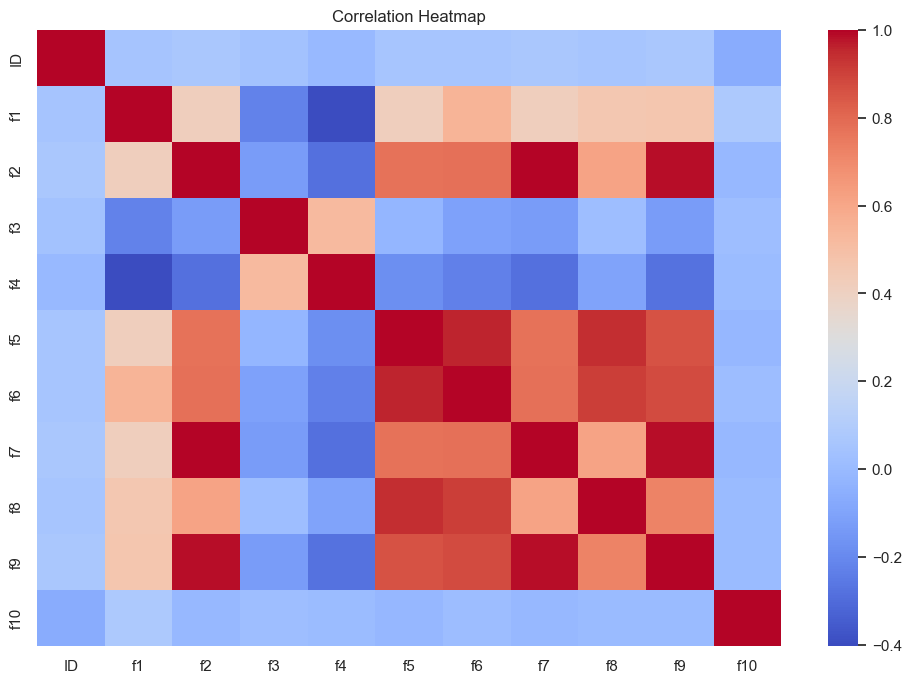

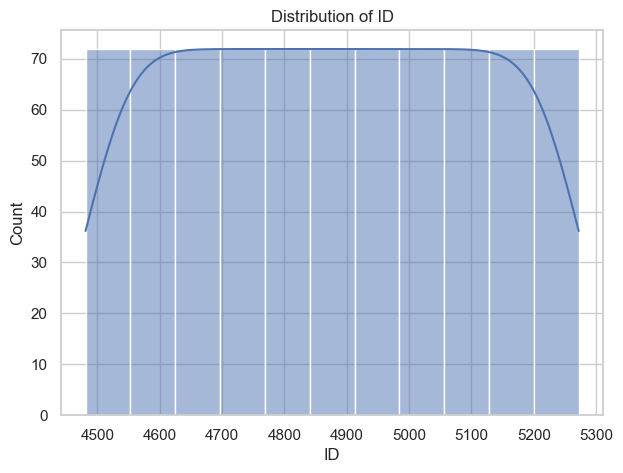

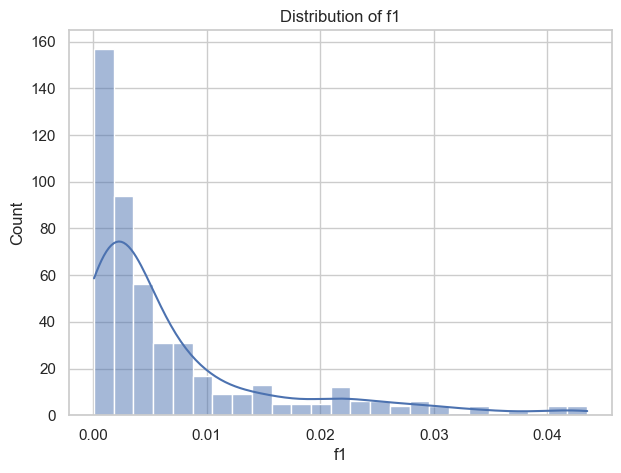

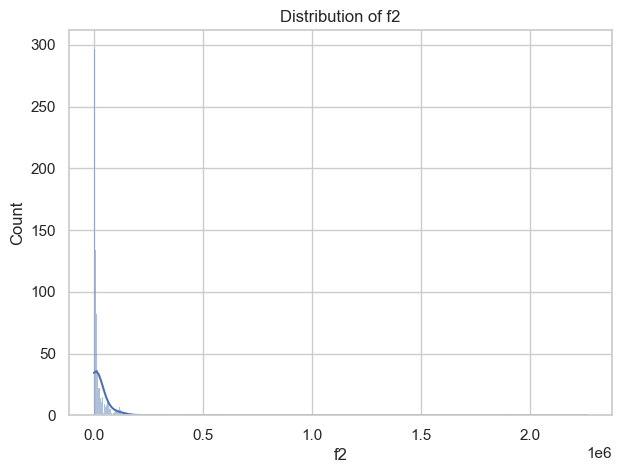

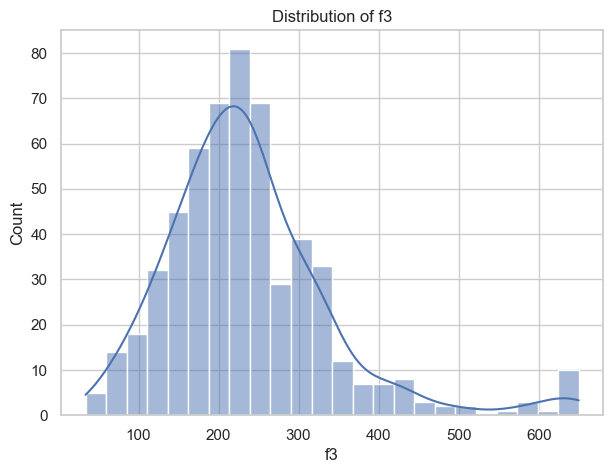

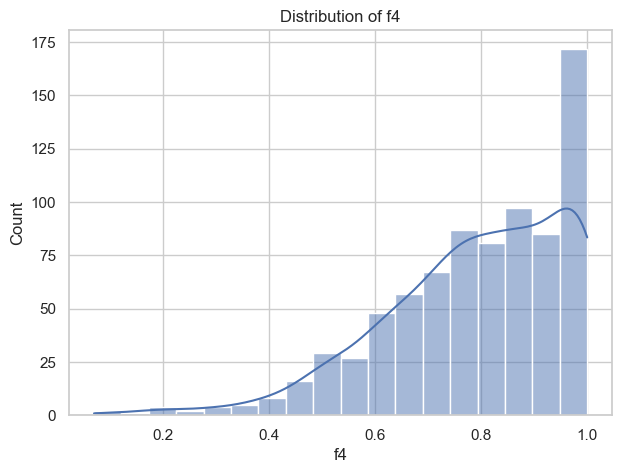

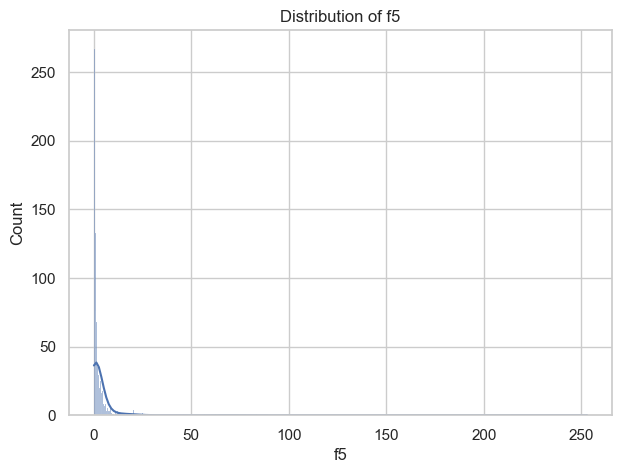

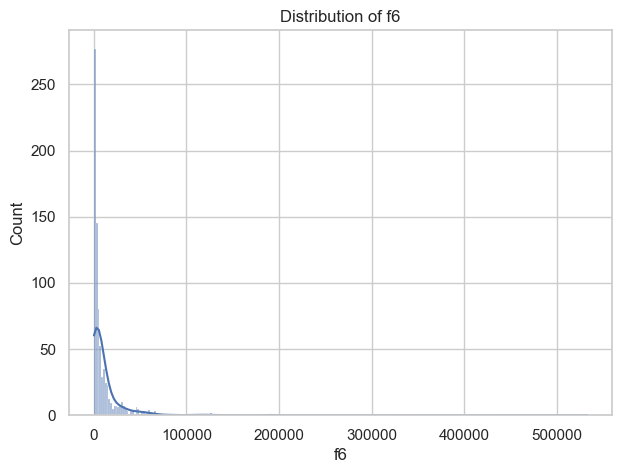

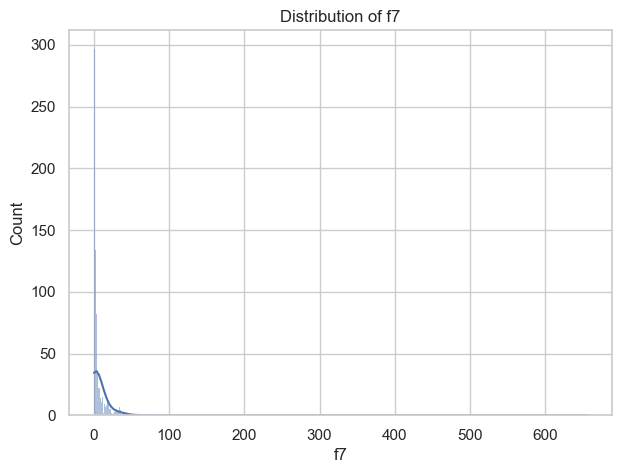

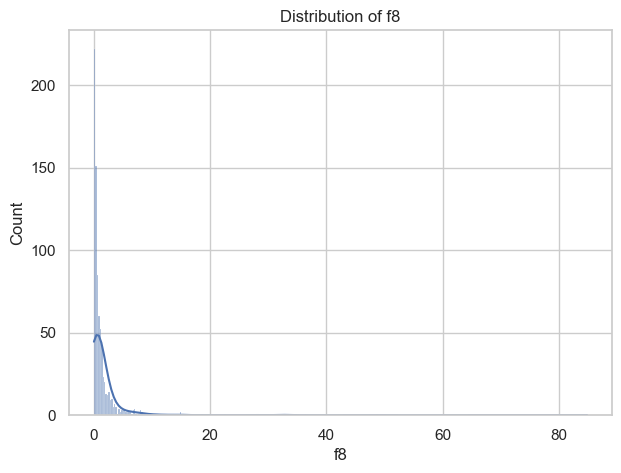

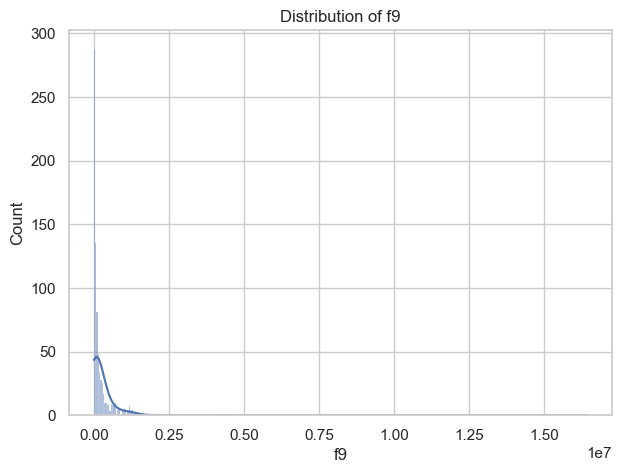

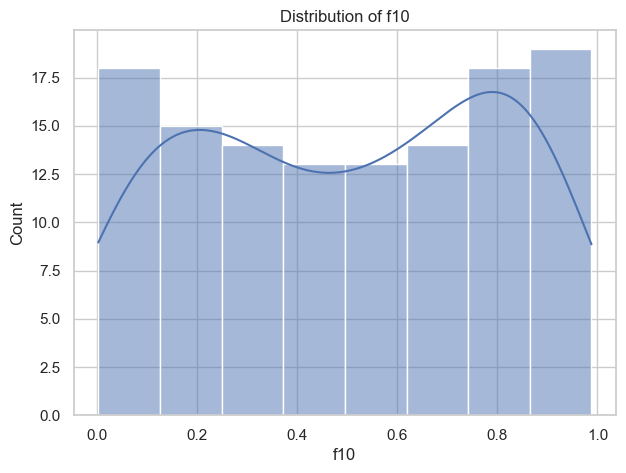

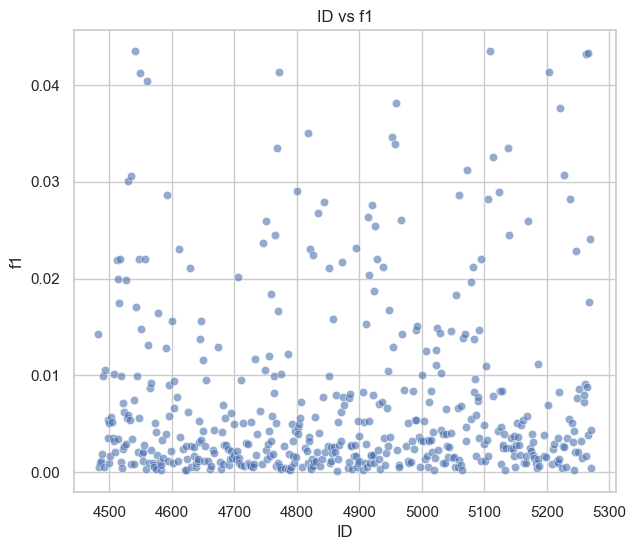

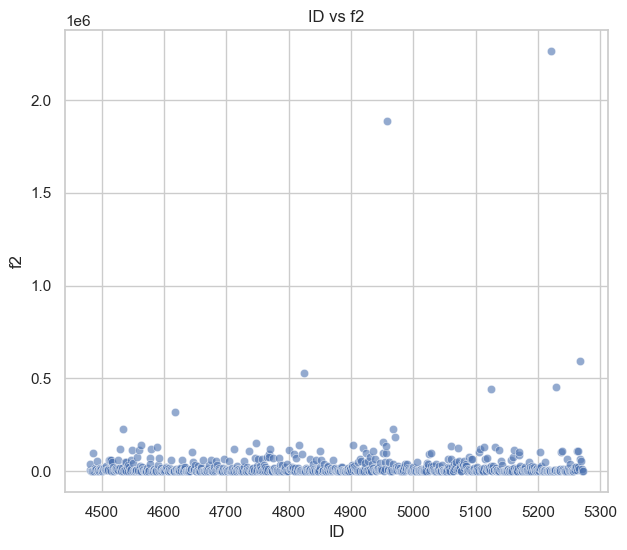

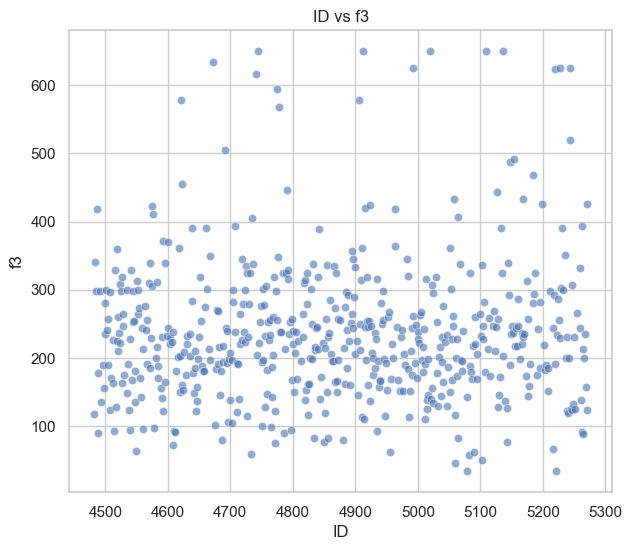

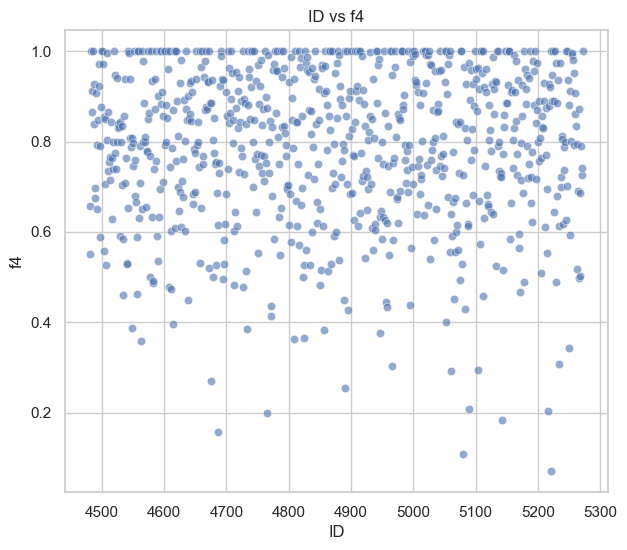

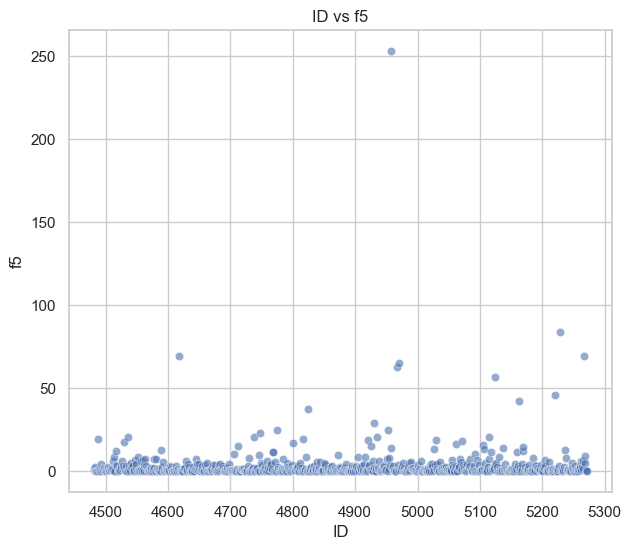

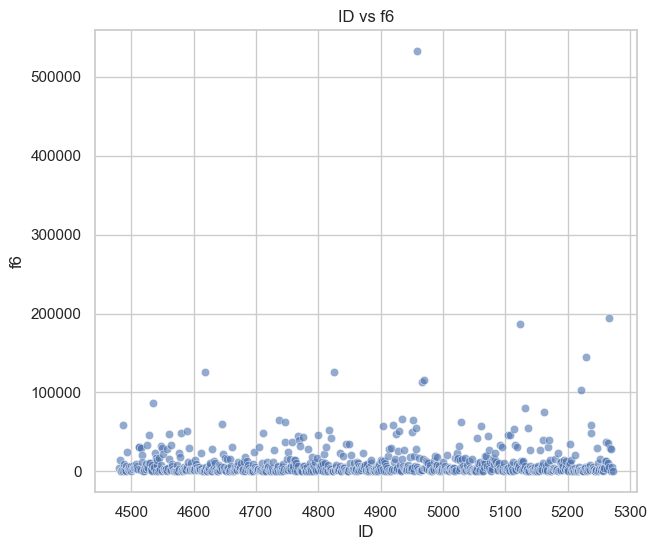

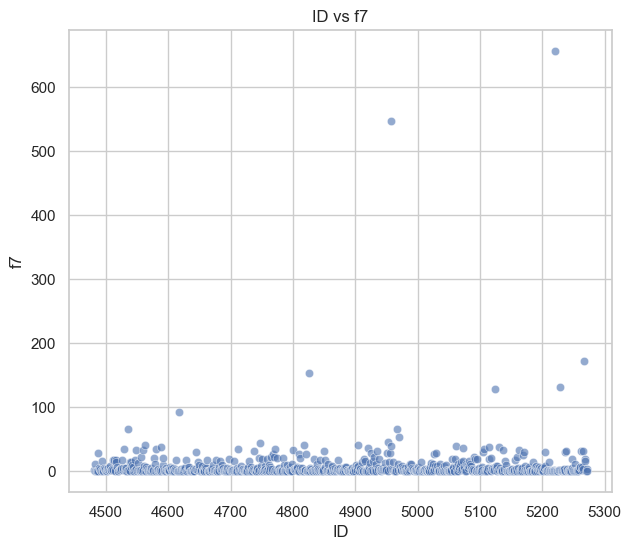

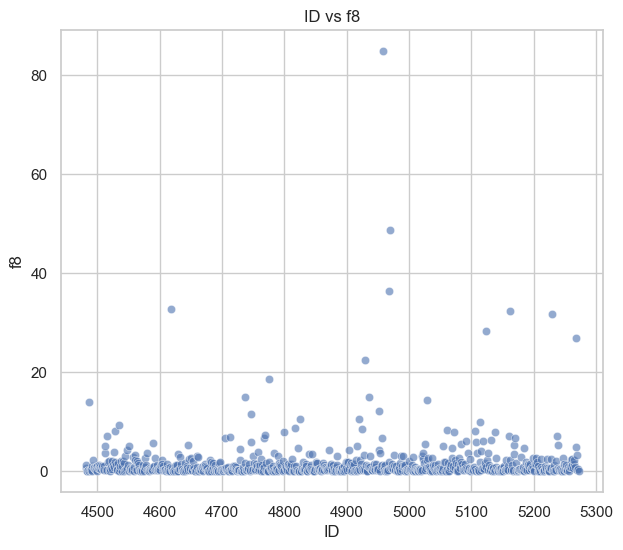

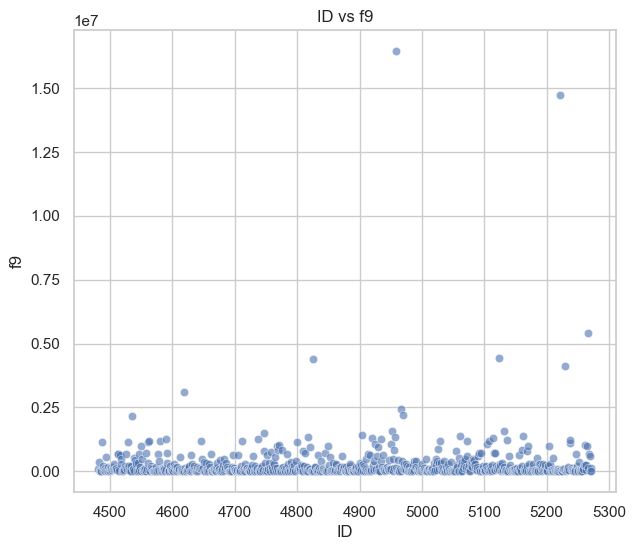

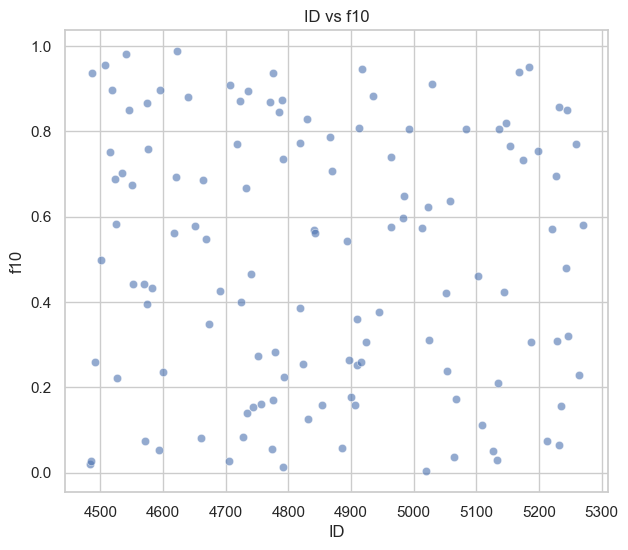

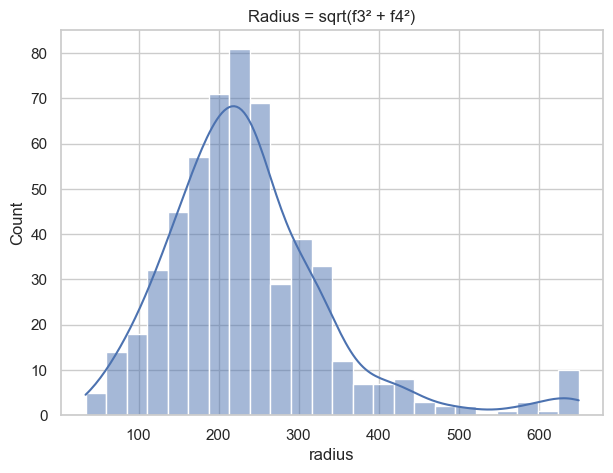

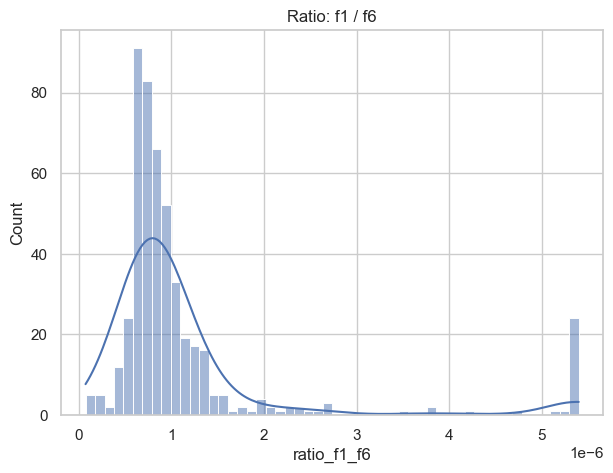

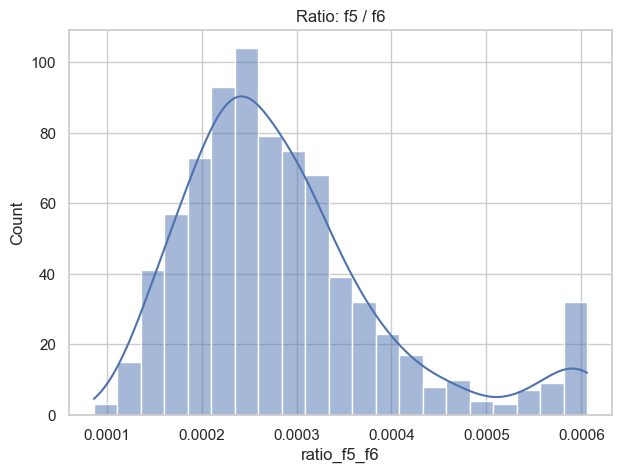

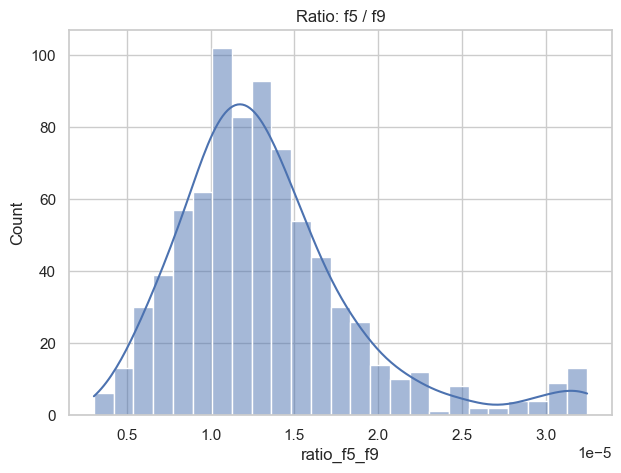

In [20]:
# ============================
# FULL ROBUST DATA VISUALIZATION SUITE
# ============================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

# ============================
# Helper
# ============================
def has_target(df, target_col):
    return target_col is not None and target_col in df.columns

# ============================
# 1) BASIC STRUCTURE CHECK
# ============================
def visualize_basic_info(df, target_col=None):
    print("Shape:", df.shape)
    print("\nMissing Values:\n", df.isna().sum())
    print("\nData Types:\n", df.dtypes)

    if has_target(df, target_col):
        print("\nTarget Distribution:\n", df[target_col].value_counts())
    else:
        print("\n[INFO] No target column found — skipping target distribution")

# ============================
# 2) CORRELATION HEATMAP
# ============================
def visualize_correlation(df, target_col=None):
    num_df = df.select_dtypes(include=["int64", "float64"])
    corr = num_df.corr()

    plt.figure(figsize=(12, 8))
    sns.heatmap(corr, cmap="coolwarm", annot=False)
    plt.title("Correlation Heatmap")
    plt.show()

    if has_target(df, target_col):
        print("\nTop Correlations with Target:")
        print(corr[target_col].abs().sort_values(ascending=False).head(15))

# ============================
# 3) DISTRIBUTIONS (KDE / HIST)
# ============================
def visualize_distributions(df, target_col=None):
    num_cols = df.select_dtypes(include=["int64", "float64"]).columns

    for col in num_cols:
        plt.figure(figsize=(7, 5))

        if has_target(df, target_col):
            sns.kdeplot(
                data=df,
                x=col,
                hue=target_col,
                fill=True,
                common_norm=False,
                alpha=0.5
            )
        else:
            sns.histplot(df[col], kde=True)

        plt.title(f"Distribution of {col}")
        plt.show()

# ============================
# 4) SCATTER (LIMITED – IMPORTANT)
# ============================
def visualize_scatter(df, target_col=None, max_plots=10):
    num_cols = df.select_dtypes(include=["int64", "float64"]).columns
    pairs = []

    for i, c1 in enumerate(num_cols):
        for c2 in num_cols[i+1:]:
            pairs.append((c1, c2))

    for col1, col2 in pairs[:max_plots]:
        plt.figure(figsize=(7, 6))

        if has_target(df, target_col):
            sns.scatterplot(
                data=df,
                x=col1,
                y=col2,
                hue=target_col,
                alpha=0.6
            )
        else:
            sns.scatterplot(
                data=df,
                x=col1,
                y=col2,
                alpha=0.6
            )

        plt.title(f"{col1} vs {col2}")
        plt.show()

# ============================
# 5) GEOMETRIC / RATIO FEATURES
# ============================
def visualize_geometry(df, target_col=None):
    df = df.copy()

    # ---- Radius ----
    if {"f3", "f4"}.issubset(df.columns):
        df["radius"] = np.sqrt(df["f3"]**2 + df["f4"]**2)

        plt.figure(figsize=(7, 5))
        if has_target(df, target_col):
            sns.kdeplot(
                data=df,
                x="radius",
                hue=target_col,
                fill=True,
                common_norm=False
            )
        else:
            sns.histplot(df["radius"], kde=True)

        plt.title("Radius = sqrt(f3² + f4²)")
        plt.show()

    # ---- Ratios ----
    ratios = [
        ("f1", "f6"),
        ("f5", "f6"),
        ("f5", "f9"),
    ]

    for a, b in ratios:
        if {a, b}.issubset(df.columns):
            df[f"ratio_{a}_{b}"] = df[a] / (df[b] + 1e-6)

            plt.figure(figsize=(7, 5))
            if has_target(df, target_col):
                sns.kdeplot(
                    data=df,
                    x=f"ratio_{a}_{b}",
                    hue=target_col,
                    fill=True,
                    common_norm=False
                )
            else:
                sns.histplot(df[f"ratio_{a}_{b}"], kde=True)

            plt.title(f"Ratio: {a} / {b}")
            plt.show()

# ============================
# 6) RUN ALL
# ============================
def full_visualization(df, target_col=None):
    visualize_basic_info(df, target_col)
    visualize_correlation(df, target_col)
    visualize_distributions(df, target_col)
    visualize_scatter(df, target_col)
    visualize_geometry(df, target_col)



# ===============================
# Load Data
# ===============================
train = pd.read_csv('dataset-train-vf.csv')
test = pd.read_csv('dataset-test-vf.csv')
submission = pd.read_csv('Submission.csv')

print(f"Train Shape: {train.shape}")
print(f"Test Shape: {test.shape}")

full_visualization(test, target_col=None)
